# Graduation Rate Data Exploration
In this notebook we look at elementary/secondary school data from the United States to hopefully shed some light on the challenges facing schools and school districts around the country. We are going to work through the entire data modeling pipeline from data acquisition -> data wrangling -> data exploration -> visualization -> modeling

### Questions
1. Where are schools struggling the most with low graduation rates?
2. Are these schools clustered in particular regions?
3. What demographic factors are correlated with low graduation rates?
4. Can we predict graduation rate and thereby reverse engineer some of the factors influencing graduation rates?

### Datasets
- <a href=https://nces.ed.gov/opengis/rest/services/K12_School_Locations/EDGE_GEOCODE_PUBLICSCH_1819/MapServer> Public School Locations </a>
- <a href=https://www2.ed.gov/about/inits/ed/edfacts/data-files/index.html#acgr> Graduation Rates </a> 
- <a href=https://data-nces.opendata.arcgis.com/datasets/nces::public-school-characteristics-2018-19/about> Demographics </a> 

### Skills In This Notebook
- REST queries
- Data Exploration
- Data Visualization
- Modeling/Prediction

***
## Imports
<code> pandas </code> data manipulation <br>
<code> plotly </code>   visualizations <br>
<code> matplotlib </code> plotting <br>
<code> seaborn </code> more visuals <br>
<code> requests </code>  manage our data scraping <br>
<code> dash </code>    interactive visualizations <br>
<code> scikitlearn </code> modeling and prediction

In [154]:
import pandas as pd
import plotly as plotly
from matplotlib import pyplot as plt
import requests as reqs
import time
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
import sklearn
import plotly.express as px
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from requests.exceptions import HTTPError
from dash.dependencies import Input, Output
from plotly.subplots import make_subplots
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

## Utility Functions
#### <code>reformat_grades(rate)</code>
removes non-numeric characters from our grades data

In [218]:
def reformat_grades(rate):
    if(rate.startswith('LE') or rate.startswith('LT') or rate.startswith('GE')):
        return rate[2:]
    if('-' in rate):
        return rate[0:rate.index('-')]
    return rate

def z_score_standardization(series):
    return (series - series.mean()) / series.std()

## Data Files
<b> df_grad_rates </b> adjusted cohort graduation rates <br>
<b> df_locations </b> latitude and longitude for schools <br>
<b> df_state_abbrevs </b> mapping between state names and two letter abbreviations <br>
<b> df_demographics </b> school demographic and other characteristic data <br>

In [192]:
df_grad_rates = pd.read_csv("../Data/18_19_Graduation_Rates.csv")
df_locations = pd.read_csv("../Data/school_geo_data.csv")
df_state_abbrevs = pd.read_csv("../Data/state_mapping.csv")
df_demographics = pd.read_csv("../Data/Public_School_Characteristics_2018-19.csv")

### Merging Data Sets
Since we are pulling data from three different locations let's get them all together so we can start to run some analysis.
To figure out our merge we are going to have a look at the columns.

In [193]:
print(df_grad_rates.columns)
print(df_locations.columns)
print(df_demographics.columns)

Index(['STNAM', 'FIPST', 'LEAID', 'ST_LEAID', 'LEANM', 'NCESSCH', 'ST_SCHID',
       'SCHNAM', 'ALL_COHORT_1819', 'ALL_RATE_1819', 'MAM_COHORT_1819',
       'MAM_RATE_1819', 'MAS_COHORT_1819', 'MAS_RATE_1819', 'MBL_COHORT_1819',
       'MBL_RATE_1819', 'MHI_COHORT_1819', 'MHI_RATE_1819', 'MTR_COHORT_1819',
       'MTR_RATE_1819', 'MWH_COHORT_1819', 'MWH_RATE_1819', 'CWD_COHORT_1819',
       'CWD_RATE_1819', 'ECD_COHORT_1819', 'ECD_RATE_1819', 'FCS_COHORT_1819',
       'FCS_RATE_1819', 'HOM_COHORT_1819', 'HOM_RATE_1819', 'LEP_COHORT_1819',
       'LEP_RATE_1819', 'DATE_CUR'],
      dtype='object')
Index(['NAME', 'STATE', 'LAT', 'LON', 'LOCALE'], dtype='object')
Index(['X', 'Y', 'OBJECTID', 'NCESSCH', 'SURVYEAR', 'STABR', 'LEAID',
       'ST_LEAID', 'LEA_NAME', 'SCH_NAME', 'LSTREET1', 'LSTREET2', 'LCITY',
       'LSTATE', 'LZIP', 'LZIP4', 'PHONE', 'GSLO', 'GSHI', 'VIRTUAL', 'TOTFRL',
       'FRELCH', 'REDLCH', 'PK', 'KG', 'G01', 'G02', 'G03', 'G04', 'G05',
       'G06', 'G07', 'G08', 'G0

**This is alot of data columns and many of them are pretty hard to interpret. Let's simplify this for our analysis**

In [194]:
df_grad_rates = df_grad_rates[['STNAM','LEAID','ST_LEAID','SCHNAM','ALL_RATE_1819']]
df_demographics = df_demographics[['LEAID', 'ST_LEAID', 'SCH_NAME', 'LSTATE','TOTFRL', 'TOTAL', 'FTE', 'LATCOD','LONCOD', 'STUTERATIO','AM', 'HI', 'BL', 'WH', 'HP','AS', 'TR','AMALF', 'ASALM', 'ASALF', 'HIALM', 'HIALF', 'BLALM', 'BLALF', 'WHALM',
       'WHALF', 'HPALM', 'HPALF', 'TRALM', 'TRALF', 'TOTMENROL', 'TOTFENROL', 'CHARTER_TEXT','MAGNET_TEXT']]

**Looks like we have a state name and a school name in all three of our dataframes. Let's have a look at these to ensure they contain what we want.**

In [195]:
print(df_grad_rates.STNAM.value_counts().head())
print(df_locations.STATE.value_counts().head())
print(df_demographics.LSTATE.value_counts().head())

CALIFORNIA    2538
TEXAS         1782
NEW YORK      1255
MICHIGAN      1111
FLORIDA       1045
Name: STNAM, dtype: int64
CA    10440
TX     9467
NY     4847
FL     4462
IL     4295
Name: STATE, dtype: int64
CA    10439
TX     9423
NY     4811
IL     4345
FL     4236
Name: LSTATE, dtype: int64


**We have a lot more data in our locations and demographics, but that makes sense since graduation rates are only being reported for high schools.**
<br>One thing we do need to fix is the state names are not abbreviated, so we are going to need to fix that before we merge. Then we are going to do a left merge onto our graduation rate dataframe because we only want to keep the data for schools in our graduation rate data.

In [196]:
#Replace state names with abbreviations
df_grad_rates['STNAM'] = df_grad_rates['STNAM'].str.lower()
df_state_abbrevs['Name'] = df_state_abbrevs['Name'].str.lower()
df_grad_rates = pd.merge(df_grad_rates,df_state_abbrevs, left_on='STNAM', right_on='Name').drop(['STNAM','Name'], axis=1)

**Let's do our merge, and we are going to use as much matching data as we can, because there are lots of schools and many of them have similar names. We are going to see that we even still have some duplicates in our data.**

In [197]:
df_full = pd.merge(df_grad_rates,df_demographics,how="left",left_on=['SCHNAM','Abbreviation','LEAID','ST_LEAID'],right_on=['SCH_NAME','LSTATE', 'LEAID','ST_LEAID'])
print(df_full.Abbreviation.value_counts().head())
df_full = pd.merge(df_full,df_locations,how="left",left_on=["SCHNAM","Abbreviation", 'LATCOD', 'LONCOD'],right_on=["NAME","STATE",'LAT','LON'])
print(df_full.Abbreviation.value_counts().head())
print(df_full.shape)
print(df_full.columns)

CA    2538
TX    1784
NY    1255
MI    1111
FL    1049
Name: Abbreviation, dtype: int64
CA    2538
TX    1809
NY    1255
MI    1111
FL    1054
Name: Abbreviation, dtype: int64
(22644, 42)
Index(['LEAID', 'ST_LEAID', 'SCHNAM', 'ALL_RATE_1819', 'Abbreviation',
       'SCH_NAME', 'LSTATE', 'TOTFRL', 'TOTAL', 'FTE', 'LATCOD', 'LONCOD',
       'STUTERATIO', 'AM', 'HI', 'BL', 'WH', 'HP', 'AS', 'TR', 'AMALF',
       'ASALM', 'ASALF', 'HIALM', 'HIALF', 'BLALM', 'BLALF', 'WHALM', 'WHALF',
       'HPALM', 'HPALF', 'TRALM', 'TRALF', 'TOTMENROL', 'TOTFENROL',
       'CHARTER_TEXT', 'MAGNET_TEXT', 'NAME', 'STATE', 'LAT', 'LON', 'LOCALE'],
      dtype='object')


**Looks like we have a few duplicate rows since we see an increase in the size of our dataframe. Let's get rid of those dupes**

In [198]:
df_full.drop(['LEAID', 'ST_LEAID','Abbreviation', 'SCH_NAME', 'LATCOD', 'LONCOD', 'NAME', 'LSTATE', 'LOCALE'],axis=1, inplace=True)
df_full.drop_duplicates(inplace=True)
print(df_full.STATE.value_counts().head()) 
print(df_full.shape)

CA    2024
TX    1437
NY    1144
MI     971
FL     935
Name: STATE, dtype: int64
(22607, 33)


## Data Wrangling and Data Exploration

**Reformat our grades column and drop our rows where we don't have data because it was flagged as protected**

In [199]:
df_full = df_full[df_full.ALL_RATE_1819 != 'PS'] #drop all rows for schools where data was protected
df_full['ALL_RATE_1819'] = df_full['ALL_RATE_1819'].apply(reformat_grades).astype('int32') #remove letters and symbols from graduation rates

**Check distribution of our graduation rates**

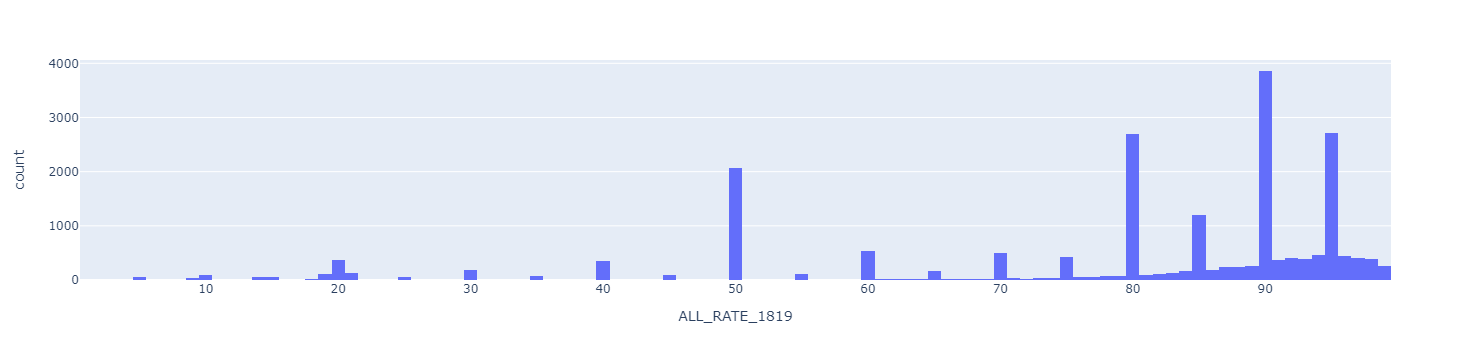

In [200]:
fig = px.histogram(df_full["ALL_RATE_1819"].sort_values(), x="ALL_RATE_1819")
fig.show()

**Data is clearly skewed to the right, and we are seeing buckets every 5 count** <br>
What if we group the graduation rates by state.

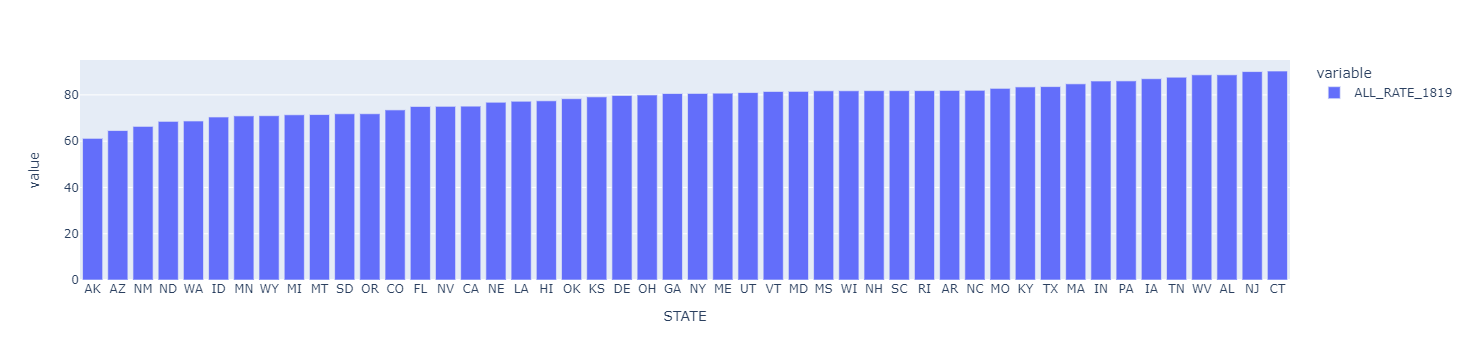

In [167]:
state_avg_grad_rates = df_full.groupby('STATE').ALL_RATE_1819.mean().sort_values()
px.bar(state_avg_grad_rates)

### Relationships with Our Target Variable

In [168]:
print(df_full.columns)
df_full.describe()

Index(['SCHNAM', 'ALL_RATE_1819', 'TOTFRL', 'TOTAL', 'FTE', 'STUTERATIO', 'AM',
       'HI', 'BL', 'WH', 'HP', 'AS', 'TR', 'AMALF', 'ASALM', 'ASALF', 'HIALM',
       'HIALF', 'BLALM', 'BLALF', 'WHALM', 'WHALF', 'HPALM', 'HPALF', 'TRALM',
       'TRALF', 'TOTMENROL', 'TOTFENROL', 'CHARTER_TEXT', 'MAGNET_TEXT',
       'STATE', 'LAT', 'LON'],
      dtype='object')


,ALL_RATE_1819,TOTFRL,TOTAL,FTE,STUTERATIO,AM,HI,BL,WH,HP,...,WHALM,WHALF,HPALM,HPALF,TRALM,TRALF,TOTMENROL,TOTFENROL,LAT,LON
count,21136.000000,21075.000000,21059.000000,20532.000000,20398.000000,18183.000000,20799.000000,19968.000000,20976.000000,15730.000000,...,20903.000000,20848.000000,14832.000000,14805.000000,19619.000000,19584.000000,21044.000000,21040.000000,18762.000000,18762.000000
mean,77.775170,325.461969,730.357329,44.624278,17.477194,8.733982,190.613299,113.455078,361.692935,3.693325,...,186.105918,177.326362,2.066006,1.977440,13.264183,13.330219,372.686466,357.956084,38.368188,-94.128108
std,21.218299,417.424368,751.506865,39.936654,61.488104,34.513233,373.687569,220.543492,425.286524,25.783141,...,215.683983,211.105970,13.726679,12.902458,21.341491,22.299697,381.066514,373.229030,5.576674,16.551793
min,1.000000,-9.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000,19.201972,-171.715402
25%,70.000000,63.000000,188.000000,15.000000,12.000000,0.000000,11.000000,3.000000,51.000000,0.000000,...,28.000000,24.000000,0.000000,0.000000,2.000000,1.000000,96.000000,89.000000,34.125755,-104.789009
50%,86.000000,174.000000,452.000000,31.340000,15.200000,2.000000,47.000000,20.000000,210.000000,0.000000,...,110.000000,103.000000,0.000000,0.000000,5.000000,5.000000,231.000000,222.500000,39.039020,-90.950185
75%,92.000000,419.000000,1068.000000,65.752501,18.900000,5.000000,183.000000,118.000000,531.000000,2.000000,...,272.000000,260.000000,1.000000,1.000000,16.000000,16.000000,546.000000,524.000000,42.128735,-81.743430
max,99.000000,5004.000000,14306.000000,394.000000,7950.000000,1334.000000,4270.000000,4369.000000,10196.000000,1148.000000,...,4877.000000,5319.000000,572.000000,576.000000,501.000000,647.000000,6733.000000,7573.000000,71.300337,-66.989082


In [169]:
#fix student teacher ratio

C:\Users\nlevi\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



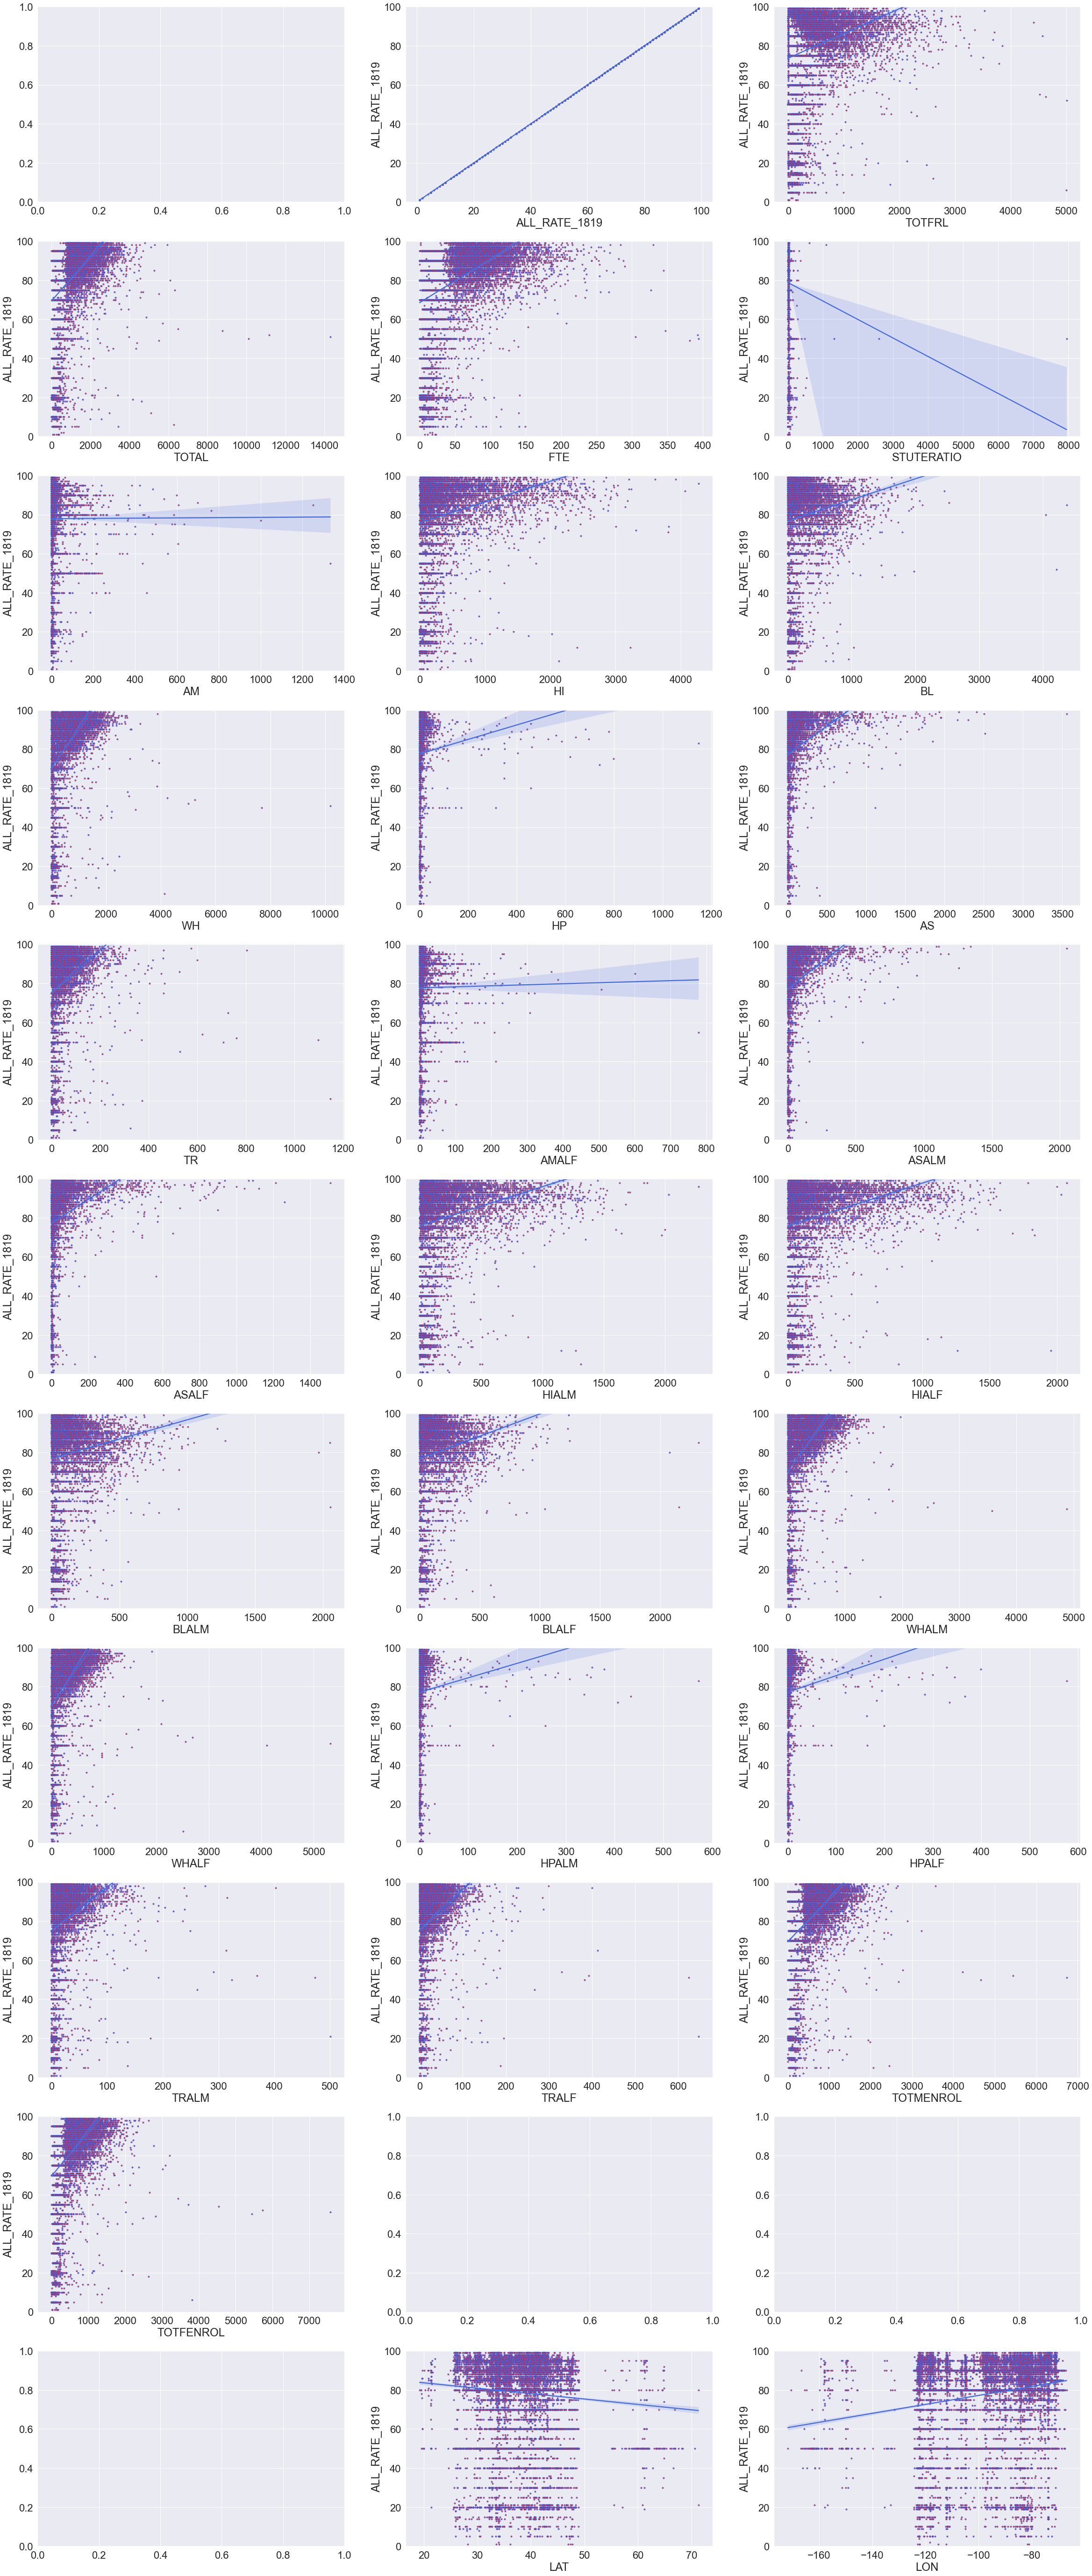

In [131]:
# defining number of rows and columns
sns.set(font_scale=2)
# creation of figure and axes
fig, axes = plt.subplots(11,3, figsize=[40,100])

# loop for plotting each column
for i, col in enumerate(df_full):
    if(is_numeric_dtype(df_full[col])):
        sns.regplot(ax=axes[i // 3, i % 3], data=df_full, x=df_full[col], y=df_full['ALL_RATE_1819'], 
                     color='royalblue', scatter_kws={'s':10, 'facecolor':'red'}).set(ylim=(0, 100))
fig.show()

In [201]:
#gender ratio
df_full["female_r"] = df_full.TOTFENROL/df_full.TOTAL
df_full["male_r"] = df_full.TOTMENROL/df_full.TOTAL

#free lunch ratio
df_full["free_lunch_r"] = df_full.TOTFRL/df_full.TOTAL
df_full.loc[~np.isfinite(df_full['free_lunch_r']), 'free_lunch_r'] = 0
#racial ratios
df_full["hispanic_r"] = df_full.HI/df_full.TOTAL
df_full.loc[~np.isfinite(df_full['hispanic_r']), 'hispanic_r'] = 0
df_full["american_indian_r"] = df_full.AM/df_full.TOTAL
df_full.loc[~np.isfinite(df_full['american_indian_r']), 'american_indian_r'] = 0
df_full["black_r"] = df_full.BL/df_full.TOTAL
df_full.loc[~np.isfinite(df_full['black_r']), 'black_r'] = 0
df_full["white_r"] = df_full.WH/df_full.TOTAL
df_full.loc[~np.isfinite(df_full['white_r']), 'white_r'] = 0
df_full["asian_r"] = df_full.AS/df_full.TOTAL
df_full.loc[~np.isfinite(df_full['asian_r']), 'asian_r'] = 0



df_full.drop(['TOTFENROL','TOTMENROL', 'HI', 'AM', 'BL', 'WH', 'AS', 'TR', 'HP', 'AMALF', 'HIALF', 'HIALM', 'BLALF', 'BLALM', 'WHALM', 'WHALF', 'ASALF', 'ASALM', 'TRALM', 'TRALF', 'HPALM', 'HPALF', 'STUTERATIO', 'FTE'],axis=1, inplace=True)

In [202]:
#Linear Regression to predict graduation rate
#charter and magnet binaries
df_full['MAGNET_TEXT'] = df_full.MAGNET_TEXT.replace({'Not Applicable':0,'Missing':0, 'No':0,'Yes':1})
df_full['CHARTER_TEXT'] = df_full.CHARTER_TEXT.replace({'Not Applicable':0,'Missing':0,'No':0,'Yes':1})

In [225]:
df_full.dropna(inplace=True)
y = df_full.ALL_RATE_1819
X = df_full.drop(['SCHNAM', 'STATE', 'LAT', 'LON', 'ALL_RATE_1819'], axis = 1)

In [226]:
#z-score standardization
for col in X.columns:
    X[col] = z_score_standardization(X[col])

In [231]:
reg = LinearRegression().fit(X,y)
r_sq = reg.score(X,y)
print(r_sq)

0.3323837705502479


**33.24% of our variation explained by our modeling. We've got a good amount of error here, but we are getting some predictive power.**

In [229]:
for index, col in enumerate(X):
    print(col, ': ', reg.coef_[index])

TOTFRL :  1.134220418559423
TOTAL :  7.110725297557679
CHARTER_TEXT :  -2.9610890021056036
MAGNET_TEXT :  0.7133743859744254
female_r :  10.917565645677167
male_r :  6.9301615449969995
free_lunch_r :  -0.66170646318513
hispanic_r :  8.382549866867542
american_indian_r :  2.8039722471272785
black_r :  7.463272416049322
white_r :  16.38930716281432
asian_r :  4.092674649969465


**Some interesting things going on in our coefficients. Ratio of white students to total students is our strongest positive coefficient. Our strongest negative coefficient here is Charter Text which is a little surprising. Seems to indicate that Charter schools overall tend to have lower cohort graduation rates. This might be explained by the high rate of churn at many Charter schools.**

## The goal of this analysis is more exploratory than predictive so let's have a look now at visualizing this data superimposed on a map of the country.

## Visualize Graduation Rate
Color scale corresponds to the level of the graduation rate. 
Slider added to the top to allow for dynamic filtering of the results

In [213]:
fig = px.scatter_geo(df_full,lat="LAT",lon="LON", color="ALL_RATE_1819", hover_name="SCHNAM", color_continuous_scale="inferno",scope='usa', width = 1200, height=800)

In [214]:


app = dash.Dash()
app.layout = html.Div([
html.P("Filter by Graduation Rate"),
dcc.Slider(min=0, max=100,value=50,id="filter_slide",tooltip={"placement": "bottom", "always_visible": True}),
dcc.Graph(id="main_chart")
])

@app.callback(
    Output('main_chart', 'figure'),
    Input('filter_slide', 'value'))
def update_output(value):
    df = df_full[df_full.ALL_RATE_1819 < value]
    fig = px.scatter_geo(df,lat="LAT",lon="LON", color="ALL_RATE_1819", hover_name="SCHNAM", color_continuous_scale="inferno",scope='usa',title="Graduation Rate By School", width = 1200, height=800)
    return fig

app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/



INFO:__main__:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
